In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam, SGD
from keras.datasets import cifar100
from keras.layers import Conv2D, MaxPooling2D,Flatten
import keras
import cv2
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import keras 
from keras.models import *
from keras.layers import *

from keras.callbacks import EarlyStopping

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [2]:
# train
directory = '/kaggle/input/chest-ctscan-images/Data/train'

data_list = []
for filename in os.listdir(directory):
    for img in os.listdir(directory+"/"+filename):
        data_list.append({'directory':directory+"/"+filename+"/"+img, 'class':filename})

data_df = pd.concat([pd.DataFrame(data_list)], ignore_index=True)

                                             directory  \
293  /kaggle/input/chest-ctscan-images/Data/train/n...   
501  /kaggle/input/chest-ctscan-images/Data/train/a...   
318  /kaggle/input/chest-ctscan-images/Data/train/l...   
329  /kaggle/input/chest-ctscan-images/Data/train/l...   
370  /kaggle/input/chest-ctscan-images/Data/train/l...   

                                             class  
293                                         normal  
501     adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib  
318  large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa  
329  large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa  
370  large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa  
large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa 000098 (3).png
(279, 425, 3)


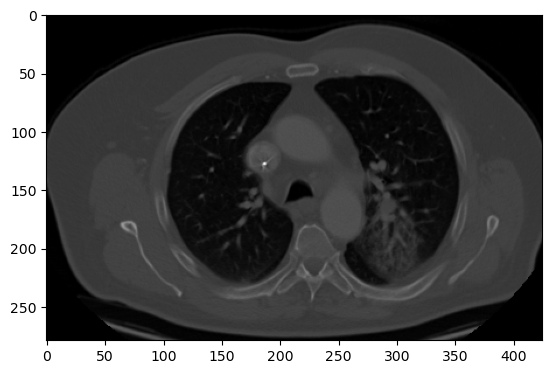

In [3]:
data_df = data_df.sample(frac = 1, random_state=7)
print(data_df.head(5))

test_img_path = data_df.iloc[2][0]
test_img = cv2.imread(test_img_path)
print(test_img_path.split("/")[-2], test_img_path.split("/")[-1])
print(test_img.shape)
plt.imshow(test_img)

In [4]:
batch_size = 64
size = (224,224,3)
img_width = img_hight = size[0]
random_state = 7

classes = list(data_df['class'].unique())

In [5]:
from keras.preprocessing.image import ImageDataGenerator

train_gen = ImageDataGenerator(rescale=1./255)
train_data = train_gen.flow_from_directory(
    '/kaggle/input/chest-ctscan-images/Data/train',target_size=(img_hight, img_hight),
    batch_size=batch_size, class_mode='categorical',
    classes=classes, seed=42,shuffle=True,subset='training')

test_gen = ImageDataGenerator(rescale=1./255)
test_data = train_gen.flow_from_directory(
    '/kaggle/input/chest-ctscan-images/Data/test',target_size=(img_hight, img_hight),
    batch_size=batch_size, class_mode='categorical',
    classes=classes, seed=42,shuffle=True)

valid_gen = ImageDataGenerator(rescale=1./255)
valid_data = train_gen.flow_from_directory(
    '/kaggle/input/chest-ctscan-images/Data/valid',target_size=(img_hight, img_hight),
    batch_size=batch_size, class_mode='categorical',
    classes=classes, seed=42,shuffle=True)



Found 613 images belonging to 4 classes.
Found 54 images belonging to 4 classes.
Found 72 images belonging to 4 classes.


In [6]:
def Create_model(Image_shape, block1=True, block2=True, block3=True,
                 block4=True, block5=True, regularizer=keras.regularizers.l2(0.0001),
                 Dropout_ratio=0.25):

    # * Create the model
    model = keras.Sequential()

    # * configure the inputshape
    model.add(keras.Input(shape=Image_shape))

    # * Add the first block
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu',
              trainable=block1))
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu',
              trainable=block1))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(BatchNormalization())

    # * Add the second block
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu',
              trainable=block2))
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu',
              trainable=block2))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())

    # * Add the third block
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu',
              trainable=block3))
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu',
              trainable=block3))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
       # * Add the fourth block
    model.add(Conv2D(512, (3, 3), padding='same', activation='relu',
              trainable=block4))
    model.add(Conv2D(512, (3, 3), padding='same', activation='relu',
              trainable=block4))
    model.add(Conv2D(512, (3, 3), padding='same', activation='relu',
              trainable=block4))

    #* flatten + Fc layer
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(Dropout_ratio))

    # * Output layer
    #model.add(Dense(3, activation='linear'))
    model.add(Dense(4, activation='softmax'))
    print('Done')
    return model
model = Create_model(size)


Done


In [7]:

# Compile the model
model.compile(Adam(), keras.losses.CategoricalCrossentropy(),metrics='accuracy')

In [8]:
results=model.fit(
    train_data,
    validation_data= test_data,
    epochs=50
  )

Epoch 1/50
10/10 [==============================] - 524s 55s/step - loss: 14.8371 - accuracy: 0.3703 - val_loss: 0.5909 - val_accuracy: 1.0000
Epoch 2/50
10/10 [==============================] - 519s 52s/step - loss: 1.1133 - accuracy: 0.4943 - val_loss: 0.1171 - val_accuracy: 1.0000
Epoch 3/50
10/10 [==============================] - 518s 52s/step - loss: 0.9457 - accuracy: 0.5873 - val_loss: 0.6617 - val_accuracy: 0.9259
Epoch 4/50
10/10 [==============================] - 518s 52s/step - loss: 0.8548 - accuracy: 0.6346 - val_loss: 0.7159 - val_accuracy: 0.9074
Epoch 5/50
10/10 [==============================] - 518s 52s/step - loss: 0.7555 - accuracy: 0.6591 - val_loss: 1.4941 - val_accuracy: 0.3519
Epoch 6/50
10/10 [==============================] - 516s 51s/step - loss: 0.7337 - accuracy: 0.7096 - val_loss: 1.3566 - val_accuracy: 0.3519
Epoch 7/50
10/10 [==============================] - 513s 54s/step - loss: 0.6160 - accuracy: 0.7194 - val_loss: 2.9471 - val_accuracy: 0.1111
Epoch

Text(0, 0.5, 'losses')

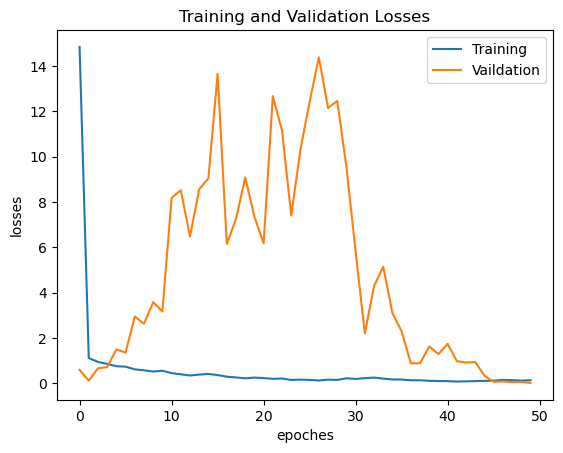

In [9]:
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.legend(['Training','Vaildation'])
plt.title('Training and Validation Losses')
plt.xlabel('epoches')
plt.ylabel('losses')

Text(0, 0.5, 'accuracy')

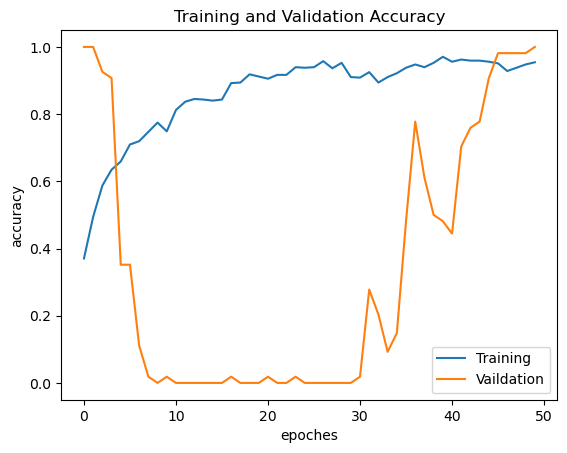

In [10]:
plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.legend(['Training','Vaildation'])
plt.title('Training and Validation Accuracy')
plt.xlabel('epoches')
plt.ylabel('accuracy')

In [11]:
y_pred= model.predict(test_data)
import numpy as np
y_pred1=np.argmax(y_pred,axis=1)

1/1 [==============================] - 13s 13s/step


In [12]:
from sklearn.metrics import accuracy_score,  confusion_matrix
confusion_matrix = confusion_matrix(test_data.labels,y_pred1)
print(confusion_matrix)

accuracy_score(test_data.labels,y_pred1)*100

[[54]]


100.0

In [13]:
from sklearn.metrics import classification_report
report=classification_report(test_data.labels,y_pred1)
print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        54

    accuracy                           1.00        54
   macro avg       1.00      1.00      1.00        54
weighted avg       1.00      1.00      1.00        54



Enter the path to the image:  /kaggle/input/chest-ctscan-images/Data/test/adenocarcinoma/000114.png


                                             directory  \
567  /kaggle/input/chest-ctscan-images/Data/train/a...   

                                          class  
567  adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib  
Image shape: (260, 439, 3)


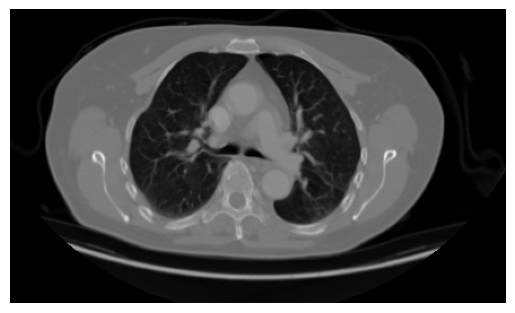

In [15]:
import cv2
import matplotlib.pyplot as plt



# Prompt the user to enter the image path
test_img_path = input("Enter the path to the image: ")

# Load the image
test_img = cv2.imread(test_img_path)

data_df = data_df.sample(frac = 1, random_state=7)
print(data_df.head(1))
# Check if the image was loaded successfully
if test_img is not None:
    # Display image shape
    print("Image shape:", test_img.shape)
    
    # Display the image
    plt.imshow(cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB))  # OpenCV reads images in BGR format, matplotlib expects RGB
    plt.axis('off')  # Hide axes
    plt.show()
else:
    print("Error: Unable to load the image. Please check the file path and ensure the image exists.")